In [96]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from chronos import BaseChronosPipeline, ChronosPipeline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [8]:
# Loading the train and validation data sets and their outcomes
data_train = pd.read_parquet('./data_processed/set-a.parquet')
data_validate = pd.read_parquet('data_processed/set-b.parquet')
data_test = pd.read_parquet('./data_processed/set-c.parquet')

outcomes_train = pd.read_csv('./data/Outcomes-a.txt')
outcomes_train = outcomes_train.loc[:, ['RecordID', 'In-hospital_death']].set_index('RecordID')
outcomes_validate = pd.read_csv('./data/Outcomes-b.txt')
outcomes_validate = outcomes_validate.loc[:, ['RecordID', 'In-hospital_death']].set_index('RecordID')
outcomes_test = pd.read_csv('./data/Outcomes-c.txt')
outcomes_test = outcomes_test.loc[:, ['RecordID', 'In-hospital_death']].set_index('RecordID')

In [69]:
data_train = pd.read_parquet('./data_processed/raw_data_set-a.parquet').drop('ICUType', axis=1)
data_validate = pd.read_parquet('data_processed/raw_data_set-b.parquet').drop('ICUType', axis=1)
data_test = pd.read_parquet('./data_processed/raw_data_set-c.parquet').drop('ICUType', axis=1)

In [92]:
def convert_df_to_tensors(df, outcomes):
    """
    Convert a DataFrame of time-series data for multiple patients into a list of PyTorch tensors.

    Each tensor corresponds to a single patient (identified by 'RecordID') and contains the 
    patient's multivariate time-series data in a [num_features, time_steps] shape.

    Assumptions:
        - The input DataFrame contains the columns 'RecordID' and 'Time'.
        - All other columns are assumed to be features.
        - The data for each patient is sorted by time (this function does not enforce sorting).

    Parameters:
        df (pd.DataFrame): A pandas DataFrame with rows representing time points and columns 
                           including 'RecordID', 'Time', and feature values.
        outcomes (pd.DataFrame): A pandas DataFrame with rows representing the outcome of 
                                 a given patient

    Returns:
        List[torch.Tensor]: A list of float tensors, each of shape [num_features, time_steps], 
                            one per unique patient.
    """
    tensors = []
    targets = []
    
    # Loop over each unique patient ID
    for ID in df['RecordID'].unique():
        # Extract data for the current patient
        patient = df[df['RecordID'] == ID]
        
        # Drop the non-feature columns and convert to NumPy array, then transpose
        # Shape becomes [num_features, time_steps]
        patient_tensor = torch.tensor(patient.drop(['RecordID', 'Time'], axis=1).to_numpy().T)
        
        # Convert to float tensor and append to list
        tensors.append(patient_tensor.float())
        
        # Creating the target tensor for the given index
        target = torch.tensor(outcomes.loc[ID].values).float()
        targets.append(target)
        
    return tensors, targets

In [18]:
class LinearProbe(nn.Module):
    """
    A simple linear probe for classification tasks.

    This module applies a single linear transformation to the input embeddings.
    Typically used to evaluate the quality of pretrained or fixed embeddings
    in downstream tasks (e.g., binary classification).

    Args:
        input_size (int): The dimensionality of the input embedding vector.

    Forward Input:
        x (Tensor): Input tensor of shape (batch_size, input_size).

    Forward Output:
        Tensor: Logits of shape (batch_size, 1).
    """
    def __init__(self, input_size):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Linear layer projecting to a single logit

    def forward(self, x):
        return self.linear(x)  # Return raw logit for BCEWithLogitsLoss or sigmoid


In [19]:
def train_model(model, criterion, X_train, y_train, X_val, y_val, initial_parameter=None, num_epochs=100):
    """
    Trains a PyTorch model using a given loss criterion and optimizer, and evaluates on a validation set.

    Args:
        model (nn.Module): The PyTorch model to train.
        criterion (nn.Module): Loss function, e.g., nn.BCEWithLogitsLoss().
        X_train (Tensor): Training input features (Tensor).
        y_train (Tensor): Training labels (Tensor).
        X_val (Tensor): Validation input features (Tensor).
        y_val (Tensor): Validation labels (Tensor).
        initial_parameter (float, optional): If specified, fills all model parameters with this value before training.
        num_epochs (int): Number of training epochs. Default is 100.

    Returns:
        Tuple:
            - model (nn.Module): The trained model.
            - metrics (dict): Dictionary containing training/validation losses, accuracies, AUROCs, and AUPRCs.
    """
    # Ensure labels are 1D
    y_train = y_train.squeeze()
    y_val = y_val.squeeze()
    
    # Convert validation labels to numpy once (for metric computation)
    y_val_numpy = y_val.cpu().numpy()
    
    # Metrics to collect during training
    train_losses = []
    val_losses = []
    accuracies = []
    aurocs = []
    auprcs = []

    # Optional: initialize all model parameters to a fixed value
    if initial_parameter != None:
        with torch.no_grad():
            for param in model.parameters():
                param.fill_(initial_parameter)
                param.requires_grad_(True)

    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters())

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        y_pred = model(X_train).squeeze()  # Forward pass on training data

        loss = criterion(y_pred, y_train)  # Compute training loss
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        y_pred = model(X_val).squeeze()  # Forward pass on validation data

        loss = criterion(y_pred, y_val)  # Compute validation loss
        val_losses.append(loss.item())

        # Compute metrics
        predictions = torch.sigmoid(y_pred).round().detach().cpu().numpy()
        accuracies.append(accuracy_score(y_val_numpy, predictions))
        aurocs.append(roc_auc_score(y_val_numpy, predictions))
        auprcs.append(average_precision_score(y_val_numpy, predictions))

        # Early stopping logic placeholder (commented out)
        # if best_val_loss - loss < 1e-3:
        #     break
        # else:
        #     best_val_loss = loss
        
    return model, {
        'train losses': train_losses,
        'val losses': val_losses,
        'accuracies': accuracies,
        'aurocs': aurocs,
        'auprcs': auprcs
    }


In [20]:
def test_model(model, criterion, X_test, y_test):
    """
    Evaluates a trained model on a test dataset using various binary classification metrics.

    Args:
        model (nn.Module): The trained PyTorch model.
        criterion (nn.Module): Loss function used during evaluation, e.g., nn.BCEWithLogitsLoss().
        X_test (Tensor): Test input features.
        y_test (Tensor): Test labels.

    Returns:
        Tuple:
            - loss (Tensor): Loss value on the test set.
            - accuracy (float): Classification accuracy.
            - auroc (float): Area under the ROC curve.
            - auprc (float): Area under the precision-recall curve.
            - conf_matrix (ndarray): Confusion matrix as a NumPy array.
    """
    # Ensure labels are 1D
    y_test = y_test.squeeze()
    
    # Store a NumPy version of the ground truth labels for metric computation
    y_test_numpy = y_test.cpu().numpy()

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for evaluation
        y_pred = model(X_test).squeeze()  # Forward pass on test data

        loss = criterion(y_pred, y_test)  # Compute test loss

        # Apply sigmoid to logits, round to binary predictions, convert to NumPy
        predictions = torch.sigmoid(y_pred).round().cpu().numpy()

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test_numpy, predictions)
        auroc = roc_auc_score(y_test_numpy, predictions)
        auprc = average_precision_score(y_test_numpy, predictions)
        conf_matrix = confusion_matrix(y_test_numpy, predictions)

    return loss, accuracy, auroc, auprc, conf_matrix


In [21]:
class AggregationNetwork(nn.Module):
    """
    A simple neural network for aggregating sequence embeddings using a 1D convolution
    followed by adaptive average pooling and a linear classifier.

    This module is useful when working with time-series or sequential data represented
    as embeddings. It reduces the sequence dimension and produces a single classification output.

    Args:
        input_size (int): The dimensionality of input features for each timestep or embedding vector.

    Input Shape:
        x (Tensor): A tensor of shape (batch_size, input_size, sequence_length),
                    where `input_size` is treated as the number of channels for Conv1d.

    Output:
        Tensor: A tensor of shape (batch_size, 1), representing raw logits for binary classification.
    """
    def __init__(self, input_size):
        super(AggregationNetwork, self).__init__()

        # 1D convolution over the sequence dimension, with padding to maintain sequence length
        self.conv = nn.Conv1d(input_size, input_size, kernel_size=3, padding=1)

        # Adaptive average pooling reduces the sequence to a single timestep (global average)
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Final linear layer maps the pooled feature vector to a single logit
        self.classifier = nn.Linear(input_size, 1)
        
    def forward(self, x):
        # x: (batch_size, input_size, sequence_length)
        x = self.conv(x)                  # -> (batch_size, input_size, sequence_length)
        x = self.pool(x).squeeze(-1)      # -> (batch_size, input_size)

        return self.classifier(x)         # -> (batch_size, 1)


In [73]:
tensors_train, targets_train = convert_df_to_tensors(data_train, outcomes_train)
tensors_val, targets_val = convert_df_to_tensors(data_validate, outcomes_validate)
tensors_test, targets_test = convert_df_to_tensors(data_test, outcomes_test)

In [74]:
y_train = torch.stack(targets_train)
y_val = torch.stack(targets_val)
y_test = torch.stack(targets_test)

In [75]:
model_type = 'tiny'
pipeline = BaseChronosPipeline.from_pretrained(
    f"amazon/chronos-t5-{model_type}", 
    device_map=device,  # use "cpu" for CPU inference,
    torch_dtype=torch.float32)

In [76]:
embeddings_train = []
for tensor in tqdm(tensors_train):
    embeddings_train.append(pipeline.embed(tensor)[0].mean(axis=-1))

X_train = torch.stack(embeddings_train).mean(axis=-1)

100%|██████████████████████████████████████| 4000/4000 [00:32<00:00, 122.55it/s]


In [77]:
embeddings_val = []
for tensor in tqdm(tensors_val):
    embeddings_val.append(pipeline.embed(tensor)[0].mean(axis=-1))

X_val = torch.stack(embeddings_val).mean(axis=-1)

100%|██████████████████████████████████████| 4000/4000 [00:32<00:00, 121.79it/s]


In [78]:
embeddings_test = []
for tensor in tqdm(tensors_test):
    embeddings_test.append(pipeline.embed(tensor)[0].mean(axis=-1))

X_test = torch.stack(embeddings_test).mean(axis=-1)

100%|██████████████████████████████████████| 4000/4000 [00:32<00:00, 121.33it/s]


In [79]:
#torch.save(X_train, f'./embeddings/{model_type}_simple_train.pt')
#torch.save(X_val, f'./embeddings/{model_type}_simple_val.pt')
#torch.save(X_test, f'./embeddings/{model_type}_simple_test.pt')

In [93]:
model = LinearProbe(41)
criterion = nn.BCEWithLogitsLoss(pos_weight=(y_train.shape[0] - y_train.sum()) / y_train.sum())

In [94]:
trained_model, metrics = train_model(model, criterion, X_train, y_train, X_val, y_val, initial_parameter=None, num_epochs=int(5e5))
print(f'Accuracy: {metrics["accuracies"][-1]:.4f}, AuROC: {metrics["aurocs"][-1]:.4f}, AuPRC: {metrics["auprcs"][-1]:.4f}\n')

100%|██████████████████████████████████| 500000/500000 [11:32<00:00, 722.15it/s]

Accuracy: 0.6757, AuROC: 0.6707, AuPRC: 0.2165



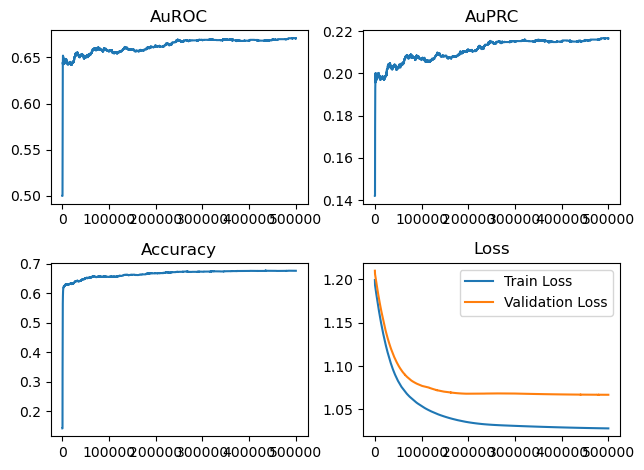

In [97]:
plt.subplot(2, 2, 1)
plt.plot(metrics['aurocs'])
plt.title('AuROC')

plt.subplot(2, 2, 2)
plt.plot(metrics['auprcs'])
plt.title('AuPRC')

plt.subplot(2, 2, 3)
plt.plot(metrics['accuracies'])
plt.title('Accuracy')

plt.subplot(2, 2, 4)
plt.plot(metrics['train losses'], label='Train Loss')
plt.plot(metrics['val losses'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [98]:
test_loss, test_accuracy, test_auroc, test_auprc, test_conf_matrix = test_model(trained_model, criterion, X_test, y_test)
print(f'Loss: {test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nAuROC: {test_auroc:.4f}\nAuPRC: {test_auprc:.4f}')

Loss: 1.0617
Accuracy: 0.7180
AuROC: 0.6854
AuPRC: 0.2380


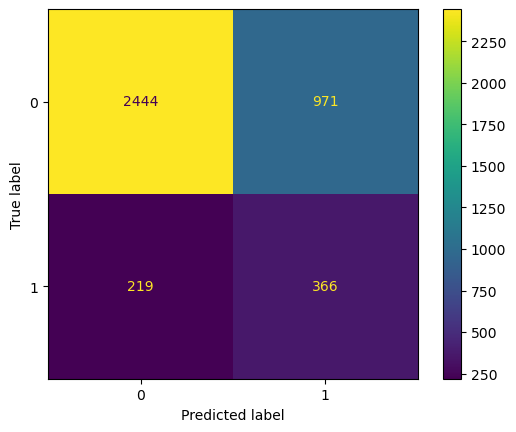

In [84]:
ConfusionMatrixDisplay(test_conf_matrix).plot()
plt.show()

In [85]:
X_train2 = torch.stack(embeddings_train)
X_val2 = torch.stack(embeddings_val)
X_test2 = torch.stack(embeddings_test)

In [86]:
torch.save(X_train2, f'./embeddings/{model_type}_agg_train.pt')
torch.save(X_val2, f'./embeddings/{model_type}_agg_val.pt')
torch.save(X_test2, f'./embeddings/{model_type}_agg_test.pt')

In [87]:
model2 = AggregationNetwork(41)

In [88]:
trained_model2, metrics = train_model(model2, criterion, X_train2, y_train, X_val2, y_val, num_epochs=1500)

100%|█████████████████████████████████████████| 500/500 [02:21<00:00,  3.53it/s]


In [89]:
print(f'Accuracy: {metrics["accuracies"][-1]:.4f}, AuROC: {metrics["aurocs"][-1]:.4f}, AuPRC: {metrics["auprcs"][-1]:.4f}\n')

Accuracy: 0.6500, AuROC: 0.6543, AuPRC: 0.2047



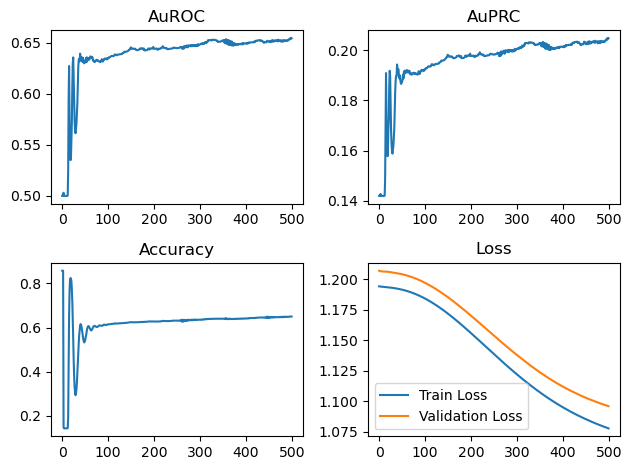

In [90]:
plt.subplot(2, 2, 1)
plt.plot(metrics['aurocs'])
plt.title('AuROC')

plt.subplot(2, 2, 2)
plt.plot(metrics['auprcs'])
plt.title('AuPRC')

plt.subplot(2, 2, 3)
plt.plot(metrics['accuracies'])
plt.title('Accuracy')

plt.subplot(2, 2, 4)
plt.plot(metrics['train losses'], label='Train Loss')
plt.plot(metrics['val losses'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [91]:
test_loss, test_accuracy, test_auroc, test_auprc, test_conf_matrix = test_model(trained_model2, criterion, X_test2, y_test)
print(f'Loss: {test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nAuROC: {test_auroc:.4f}\nAuPRC: {test_auprc:.4f}')

Loss: 1.1106
Accuracy: 0.7103
AuROC: 0.6589
AuPRC: 0.2201


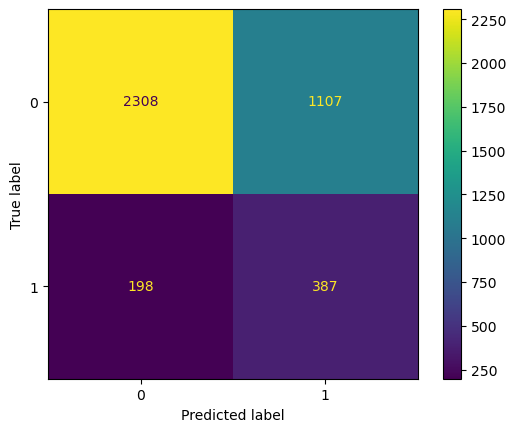

In [50]:
ConfusionMatrixDisplay(test_conf_matrix).plot()
plt.show()

In [2]:
np.logspace(-3, 3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [48]:
for name, param in model.named_parameters():
    print(name)
    print(f'{name}: {param}')

linear.weight
linear.weight: Parameter containing:
tensor([[   1.3263, -104.6468,    1.3025,    1.4325,   -1.3036,  -70.9426,
           21.5983,  -17.0778,  -63.7122, -107.9769,   84.4868,  -42.9405,
           57.5254,  -48.7393,  106.4937,  -23.7677,   -7.6163,   30.9957,
           -1.1519,   28.5229,  -81.6220,  -36.7694,   53.8595,    1.3168,
         -104.0480,   23.6794,   22.1188,  -44.3022,  -14.0679,  -77.6065,
          -43.8786,   20.4543,  108.1196,   85.2752,  -99.0770,  -43.5104,
         -109.1193,  -87.9118,   55.9588,  -54.1400,  109.3642]],
       requires_grad=True)
linear.bias
linear.bias: Parameter containing:
tensor([1.5565], requires_grad=True)
